# Task 1 - Sentiment Model

## Data Extraction - code from data_loader_demo.ipynb

In [2]:
%load_ext autoreload
%autoreload 2

import warnings

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Exploration
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
import numpy as np
import pandas as pd

import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
import params as p
import functions as f

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

import optuna

In [3]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jamesstephenson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jamesstephenson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Settings

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import Data

In [5]:
# The financial_phrasebank dataset is available in four variations. It has no predefined train/validation/test splits.
# Each data point was annotated by 5-8 people, then their annotations were combined. 
# Each variation of the dataset contains examples with different levels of agreement. 
# Let's use the one containing all data points where at least 50% of the annotators agreed on the label.
dataset = load_dataset(
    "financial_phrasebank", 
    'sentences_50agree' # Select variation of the dataset
)

print(f'The dataset is a dictionary with two splits: \n\n{dataset}')

Reusing dataset financial_phrasebank (/Users/jamesstephenson/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/a6d468761d4e0c8ae215c77367e1092bead39deb08fbf4bffd7c0a6991febbf0)
100%|██████████| 1/1 [00:00<00:00, 63.87it/s]

The dataset is a dictionary with two splits: 

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})


In [6]:
# Split test data from training data
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    dataset["train"]['sentence'], 
    dataset["train"]['label'], 
    test_size=0.2, 
    stratify=dataset["train"]['label']  # make sure the same proportion of labels is in the test set and training set
)

In [7]:
# label 0 = negative, 1 = neutral, 2 = positive
print(f'How many instances in the train dataset? \n\n{len(train_sentences)}')
print('')
print(f'What does one instance look like? \n\n{train_sentences[234]}')

How many instances in the train dataset? 

3876

What does one instance look like? 

The Elcoteq group recently announced that the last three months of the previous year brought to it a major loss of more than half a billion kroons ( EUR 32 mln ) for the fifth quarter running .


It may also be necessary to create a _validation_ set (also called 'development' set or 'devset'). The validation set can be used to compute performance of your model when tuning hyperparameters,  optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specifso it gets good performance on the test set examples. 

In [8]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size=0.25, stratify=train_labels)


In [9]:
print(f'How many instances in the validation dataset? \n\n{len(val_sentences)}\n')
print(f'How many instances in the test dataset? \n\n{len(test_sentences)}')

How many instances in the validation dataset? 

969

How many instances in the test dataset? 

970


## Data Exploration

In [10]:
train = pd.DataFrame({'sentences' : train_sentences, 'labels' : train_labels})

### Very Brief Response Analysis

Should only need to do this for train due to random split. So would expect to see the same structure for test and val

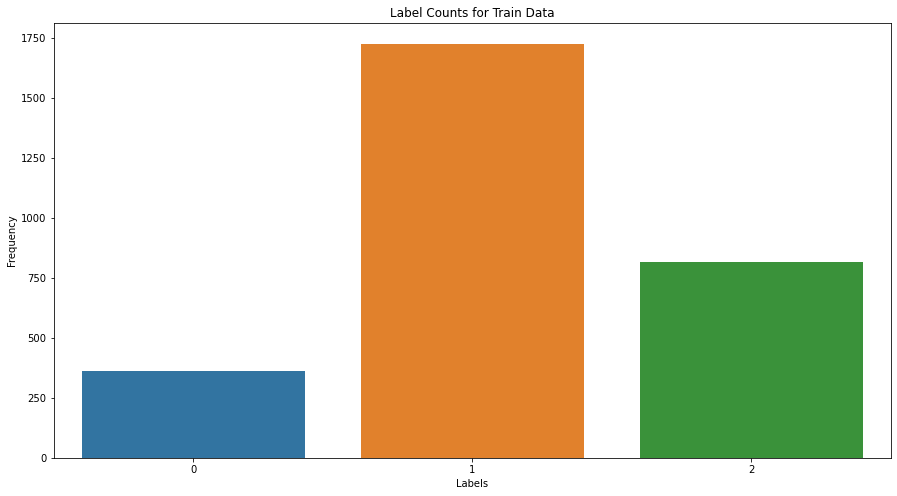

In [11]:
# Make figure and axis
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 8))

# Create plot of label counts
ax = sns.countplot(data = train, x = 'labels').set(title = 'Label Counts for Train Data')

# Edit plot to show correct labels
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks(rotation = 0)

# Show Plot
plt.show()

There is a slight imbalance in labels, but nothing that should be an issue. If we find this is an issue later on, we can perform some over or under sampling.

# Featuring Engineering

### Sentence Processing

In [75]:
# Remove some stopwords to capture negation in n-grams if possible
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

# Load up a WordNet Lemmatizer
wnl = nltk.stem.WordNetLemmatizer()

# Define a function to get the position tag for each word - this helps to lemmatize words correctly with context
def get_wordnet_pos(word: str):
        '''Map POS tag to first character lemmatize() accepts
        
        Arguments:
            word (str): word to find wordnet position tag for'''
        
        # Get first letter of pos_tag
        tag = nltk.pos_tag([word])[0][1][0].upper()

        # Translate letter into wordnet position tag
        tag_dict = {
            'J': nltk.corpus.wordnet.ADJ,
            'N': nltk.corpus.wordnet.NOUN,
            'V': nltk.corpus.wordnet.VERB,
            'R': nltk.corpus.wordnet.ADV
            }

        return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def text_preprocess(sentence: str):
    '''Preprocesses the inputted sentence and does the following: sets to lowercase,
    removes unwanted characters, lemmatizes and removes stopwords
    
    Arguments:
        sentence (str): sentence to be processed

    Returns:
        sentence (str): processed sentence'''

    # Set to lower case
    sentence = str(sentence).lower()
    
    # Remove non-letter characters and replace the abbreviation 'mn' for million
    sentence = re.sub(r'[^a-zA-Z]',r' ', sentence)
    sentence = re.sub('mn', 'million', sentence)

    # Wordnet lemmatizer with position tagging to give context
    sentence = ' '.join([wnl.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(sentence)])
    
    # Removal of Stopwords
    sentence = ' '.join([word for word in nltk.word_tokenize(sentence) if word not in stop_words])
    
    return sentence

# Turn the above function into a vectorized function to work on columns for sentences
vect_text_preprocess = np.vectorize(text_preprocess)

In [76]:
# Clean train, test and validation sentences using the vectorized text_processor
clean_train_sentences = vect_text_preprocess(train_sentences)
clean_test_sentences = vect_text_preprocess(test_sentences)
clean_val_sentences = vect_text_preprocess(val_sentences)

#### TF-IDF Vectorizer

We will be using a TF-IDF Vectorizer to vectorize our sentences before modelling. We will be setting the `ngram_range = (1, 1)` so we can also build columns for bi-grams.

In [77]:
# Define TFIDF Vectorizer
tfidf = TfidfVectorizer(min_df = 0.0, max_df = 1.0, ngram_range = (1, 1))

In [78]:
# Fit and transform the clean sentences to the TFIDF Vectorizer for each train, test and validation
X_train = tfidf.fit_transform(clean_train_sentences).toarray()
X_train = pd.DataFrame(X_train, columns = tfidf.get_feature_names_out())

X_test = tfidf.transform(clean_test_sentences).toarray()
X_test = pd.DataFrame(X_test, columns = tfidf.get_feature_names_out())

X_val = tfidf.transform(clean_val_sentences).toarray()
X_val = pd.DataFrame(X_val, columns = tfidf.get_feature_names_out())

## Modelling

We will be using the ROC AUC Score as our evaluation metric since is provides a good balance between True Negative and False Positives in one score. This is preferred to Accuracy due to our imbalance and Precision and Recall since we require a balance of the both to get a good model. Since ROC score uses predicted probabilities as its input, we don't have to tune the threshold.

In [79]:
# Assign train, text and validation labels to the y variable
y_train = train_labels
y_test = test_labels
y_val = val_labels

In [80]:
# Make a dictionary for each train, tes and validation to make fitting and evaluation cleaner.
train_data = {'X' : X_train, 'y' : y_train}
test_data = {'X' : X_test, 'y' : y_test}
val_data = {'X' : X_val, 'y' : y_val}

### Baseline Model - Linear Regression

We are using a Logistic Regressor since it is a robust model across a wide state space so should be able to deal with our sentences effectively.

In [81]:
baseline_model = LogisticRegression().fit(**train_data)
f.evaluate_model(baseline_model, **test_data, c_report = True, print_metrics = True)

 --- Classification Report --- 
              precision    recall  f1-score   support

           0       0.83      0.40      0.54       121
           1       0.73      0.95      0.83       576
           2       0.72      0.45      0.55       273

    accuracy                           0.74       970
   macro avg       0.76      0.60      0.64       970
weighted avg       0.74      0.74      0.71       970


 --- MACRO METRICS --- 
ROC: 0.86111
ACCURACY: 0.73711
PRECISION: 0.761
RECALL: 0.59659


### Model Tuning - Naive Bayes

In [82]:
warnings.simplefilter(action='ignore', category=UserWarning)

In [83]:
# Define objective we want to optimize
def objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):

    # Suggest penalty parameter for objective
    penalty_dummy = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])

    # Model requires a l1_ratio if its penalty is 'elasticnet'
    if penalty_dummy == 'elasticnet':

        l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)

    else:

        l1_ratio = None

    # Define paramters we want to adjust
    obj_params = {
        'penalty' : penalty_dummy,
        'C' : trial.suggest_uniform('C', 0, 7),
        'l1_ratio' : l1_ratio,

        'solver' : 'saga',
        'random_state' : p.RANDOM_STATE
    }

    # Create objective model
    nb_obj = LogisticRegression(**obj_params)
    nb_obj.fit(X_train, y_train)

    # Make predictions from fitted model
    y_pred = nb_obj.predict_proba(X_test)

    # Calculate roc score for model predictions
    roc = roc_auc_score(y_true = y_test, y_score = y_pred, average = 'macro', multi_class='ovr')
    
    # Return roc - metric to be maximized
    return roc

# Create optuna study to maximise objective
study = optuna.create_study(direction='maximize')

# Optimize objective for this study over 200 trails
study.optimize(objective, n_trials = 200, n_jobs = -1)

[I 2022-03-29 21:42:04,646] A new study created in memory with name: no-name-88df6a52-6318-40e8-98fc-615c2f7b0636
[I 2022-03-29 21:42:15,754] Trial 0 finished with value: 0.8638181933603367 and parameters: {'penalty': 'l2', 'C': 4.62952801966031}. Best is trial 0 with value: 0.8638181933603367.
[I 2022-03-29 21:42:16,386] Trial 3 finished with value: 0.8634487140033481 and parameters: {'penalty': 'l2', 'C': 5.15807747441389}. Best is trial 0 with value: 0.8638181933603367.
[I 2022-03-29 21:42:18,592] Trial 6 finished with value: 0.862102225641884 and parameters: {'penalty': 'l2', 'C': 6.5888803479553815}. Best is trial 0 with value: 0.8638181933603367.
[I 2022-03-29 21:42:19,067] Trial 7 finished with value: 0.862159390199504 and parameters: {'penalty': 'l2', 'C': 6.529104394953695}. Best is trial 0 with value: 0.8638181933603367.
[I 2022-03-29 21:42:23,055] Trial 1 finished with value: 0.8695601911804075 and parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.5023071692981064, 'C': 2.

In [84]:
# Copy best parameters for LR model
lr_tuned_params = study.best_params.copy()
lr_tuned_params['solver'] = 'saga'
lr_tuned_params['random_state'] = p.RANDOM_STATE
lr_tuned_params

{'penalty': 'elasticnet',
 'l1_ratio': 0.6507787244533247,
 'C': 2.671023931664704,
 'solver': 'saga',
 'random_state': 73}

In [85]:
# Create tuned LR model
lr_tuned = LogisticRegression(**lr_tuned_params).fit(**train_data)

#### Overall Evaluation

In [86]:
model = lr_tuned

# Calculate model metrics for each dataset
model_metrics = {
    'Train' : f.evaluate_model(model, **train_data),
    'Test' : f.evaluate_model(model, **test_data),
    'Validation' : f.evaluate_model(model, **val_data)
}

# Display metrics in a dataframe
pd.DataFrame(model_metrics).T

,ROC,Accuracy,Precision,Recall
Train,0.978525,0.876161,0.887635,0.801738
Test,0.870534,0.744330,0.740172,0.653939
Validation,0.858454,0.764706,0.755081,0.657873


This suggests the model is heavily over fit.

### Confusion Matrix

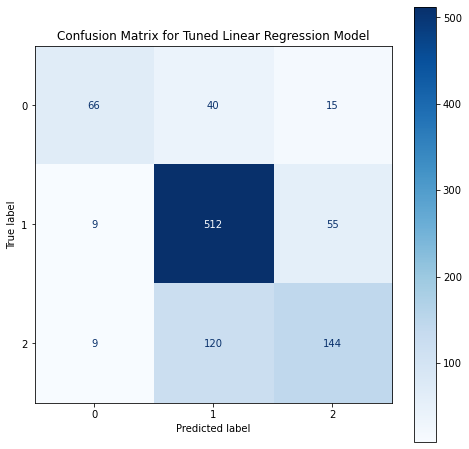

In [87]:
def create_confusion_matrix(model, model_name: str):
    """Calculates and displays a confusion matrix for model

    Args:
        model: model to evaluate
        model_name (str): name of model
    """

    # Create figure and axis to display plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Calculates confusion matrix
    plot_confusion_matrix(model, X_test, y_test, cmap="Blues", ax=ax)

    # Sets title for plot
    plt.title(f"Confusion Matrix for {model_name} Model")

    # Shows plot
    plt.show()

# Calculate confusion matrix for Tuned LR model
create_confusion_matrix(lr_tuned, "Tuned Linear Regression")

### Feature Importances

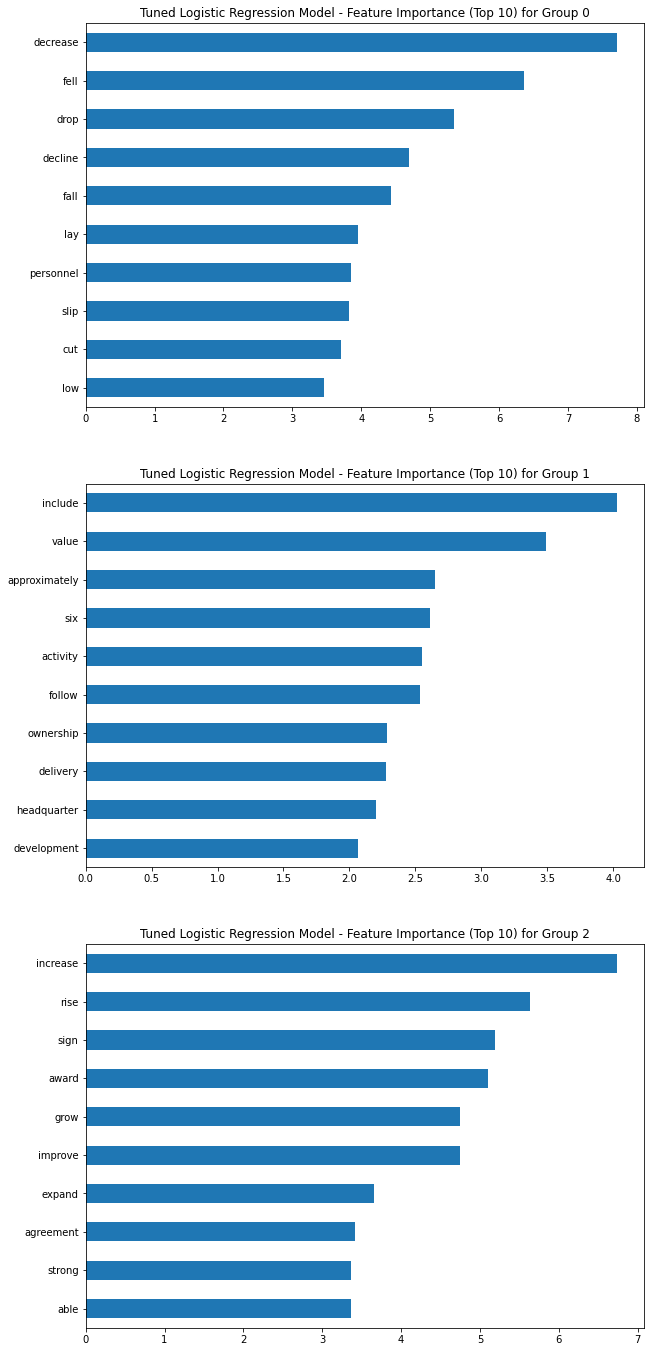

In [88]:
def plot_feature_importance(model, model_name: str, class_label: int):
    """Plots feature importances for the specified class label

    Args:
        model: model we want importances for
        model_name (str): name of model
        class_label (int): class we want to analyse (one of 0, 1 or 2)
    """

    # Create figure and axis to display plot
    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(10, 24))

    for idx, cl in enumerate([0, 1, 2]):
        # Retrive feature coefficients from model for class label
        coefs = model.coef_[cl]

        # Plot coefficients as a horizontal bar plot
        pd.Series(coefs, index=model.feature_names_in_).nlargest(10).sort_values(ascending=True).plot(
            kind="barh", ax=ax[idx], title=f"{model_name} Model - Feature Importance (Top 10) for Group {cl}"
        )

    # Show plot
    plt.show()


# Call function for Tuned LR model
plot_feature_importance(lr_tuned, "Tuned Logistic Regression", 1)
